# Implementación de Transformers para Procesamiento de Lenguaje Natural (NLP)


### Objetivo
En esta evaluación, implementaremos un modelo basado en arquitecturas de Transformers para una tarea de procesamiento de lenguaje natural (NLP), utilizando el dataset **DailyDialog**. Este conjunto de datos de diálogos permite que el modelo practique en generación de texto y comprensión de contexto en interacciones cotidianas.

Usaremos TensorFlow para construir un modelo transformer básico con las siguientes características:
- **Encoder-Decoder**: para procesar la entrada y generar salida secuencial.
- **Atención Multi-cabezal**: para capturar dependencias a largo plazo en el diálogo.

Al final, evaluaremos el modelo utilizando métricas específicas de NLP, como BLEU o ROUGE.


## ¿Como funciona un transformer?

<img src="https://arxiv.org/html/1706.03762v7/extracted/1706.03762v7/Figures/ModalNet-21.png" width="500"/>

1. Embeddings

Transforman cada palabra o token en un vector numérico de alta dimensión. Representan relaciones semánticas entre palabras. Se combinan con codificaciones posicionales (positional encoding) para mantener el orden de la secuencia, ya que el Transformer no es secuencial como los RNN.

2. Positional Encoding

Como el Transformer no procesa las secuencias de forma secuencial (a diferencia de RNN o LSTM), no tiene forma de conocer el orden de las palabras. Para solucionar esto, se suman vectores llamados positional encodings a los embeddings. Estos codifican la posición de cada palabra en la secuencia usando funciones trigonométricas (seno y coseno), permitiendo al modelo captar el orden y la distancia entre tokens.

3. Multi-Head Attention

Es una extensión del self-attention. Ejecuta múltiples mecanismos de atención en paralelo (cabezas), cada uno capturando distintos tipos de relaciones (sintácticas, semánticas, etc.). Luego, combina sus salidas para obtener una representación más rica y completa del contexto.

4. Feed-Forward Network

Después de la atención, cada token pasa por una red neuronal simple (totalmente conectada) que refuerza o transforma su representación. Es la misma para todos los tokens, pero actúa de forma independiente en cada uno.

5. Normalización y Residuos (Layer Norm + Skip Connections)

Cada subcomponente (atención o feed-forward) está seguido por una conexión residual y una normalización por capas. Esto ayuda a estabilizar y acelerar el entrenamiento, y evita la pérdida de información relevante.

6. Codificador (Encoder)

Es una pila de capas que contienen los elementos anteriores. Toma la secuencia de entrada y la transforma en una representación contextualizada. Se utiliza, por ejemplo, en tareas como clasificación o traducción.

7. Decodificador (Decoder)

También es una pila de capas similares, pero además incluye atención cruzada (cross-attention) hacia la salida del codificador. Se usa en tareas generativas como traducción o generación de texto, donde se necesita producir una secuencia de salida palabra por palabra.

8. Capa de salida

Transforma la representación final del decodificador en una predicción, normalmente usando una capa lineal seguida de softmax para generar probabilidades sobre el vocabulario.



## 1. Carga y Exploración del Dataset: DailyDialog

In [ ]:
!pip install datasets==2.16.0 fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.9.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=407f02448ad77aee5f49a83cd662c80283afa3fb469b0965c21d91e57cd27958
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ast
import re
import os
import csv
import matplotlib.pyplot as plt

from datasets import load_dataset
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
from rouge_score import rouge_scorer
from tqdm import tqdm

In [ ]:
# Cargar el dataset DailyDialog
dataset = load_dataset("daily_dialog")

# Dividir en entrenamiento y prueba
train_data, test_data, validation_data = dataset['train'], dataset['test'], dataset['validation']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/datasets/load.py:1429: FutureWarning: The repository for daily_dialog contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/daily_dialog
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Se cargaron las tres particiones que el dataset ya ofrece: entrenamiento (train), prueba (test) y validación (validation). Esta división es crucial para garantizar una evaluación objetiva del modelo.

1. El conjunto de entrenamiento se utiliza para ajustar los pesos del modelo.

2. El conjunto de validación permite monitorear el desempeño del modelo durante el entrenamiento y detectar sobreajuste.

3. Finalmente, el conjunto de prueba se emplea exclusivamente para evaluar el rendimiento final del modelo sobre datos no vistos.

## Procesamiento y preparación de la data

En esta etapa se transforma el dataset en un formato adecuado para tareas de modelado de lenguaje secuencial, específicamente para entrenar un modelo que aprenda a predecir la próxima oración dada una oración previa.

Para cada conjunto se recorre la lista de oraciones ('dialog') de cada ejemplo del dataset. Luego, se construyen pares (input → target) tomando cada oración como entrada y su oración siguiente como respuesta esperada.

Para las respuestas (target), se añaden explícitamente los tokens especiales **\<start\>** y **\<end\>**.

* **\<start\>** indica el inicio de la secuencia generada, lo que ayuda al modelo a aprender desde qué punto comenzar la predicción.

* **\<end\>** señala el final de la respuesta esperada, lo cual es esencial para que el modelo sepa cuándo detener la generación de texto.

In [ ]:
train_inputs, train_targets = [], []
val_inputs, val_targets = [], []
test_inputs, test_targets = [], []

def procesar_dataset(dataset_split, input_list, target_list):
    for ejemplo in dataset_split:
        oraciones = ejemplo['dialog']
        for i in range(len(oraciones) - 1):
            entrada = oraciones[i].strip()
            respuesta = "<start> " + oraciones[i + 1].strip() + " <end>"
            input_list.append(entrada)
            target_list.append(respuesta)

# Aplicar por separado
procesar_dataset(dataset['train'], train_inputs, train_targets)
procesar_dataset(dataset['validation'], val_inputs, val_targets)
procesar_dataset(dataset['test'], test_inputs, test_targets)

print("Ejemplo entrada:", train_inputs[9])
print("Ejemplo respuesta:", train_targets[9])

Ejemplo entrada: Can you do push-ups ?
Ejemplo respuesta: <start> Of course I can . It's a piece of cake ! Believe it or not , I can do 30 push-ups a minute . <end>


### Tokenización y vectorización del lenguaje

Se utiliza un tokenizador que:

* No elimina signos de puntuación (filters=''), ya que estos pueden contener información útil en el contexto de los diálogos.

* Convierte todo el texto a minúsculas (lower=True), lo que reduce el tamaño del vocabulario y evita que el modelo trate como diferentes palabras que solo difieren en mayúsculas.

* Incluye un token especial (\<OOV\>) para representar aquellas palabras que no se encuentren en el vocabulario durante la inferencia, lo cual mejora la robustez del modelo frente a entradas desconocidas.

Una vez entrenado el tokenizador, se convierte cada texto a una secuencia de enteros, donde cada entero representa una palabra o subpalabra. Luego, se aplica padding a las secuencias para que todas tengan la misma longitud. Esto es esencial para permitir el procesamiento por lotes en redes neuronales, ya que estas requieren entradas de forma uniforme.

In [ ]:
# 1. Preparar textos de entrenamiento para ajustar el tokenizer
all_texts = train_inputs + train_targets

# 2. Crear el tokenizer
tokenizer = Tokenizer(filters='', lower=True, oov_token='<OOV>')
tokenizer.fit_on_texts(all_texts)

# 3. Convertir textos a secuencias
def textos_a_tensor(inputs, targets, tokenizer, max_len=None):
    input_seq = tokenizer.texts_to_sequences(inputs)
    target_seq = tokenizer.texts_to_sequences(targets)

    # Padding
    if not max_len:
        max_len = max(max(len(s) for s in input_seq), max(len(s) for s in target_seq))

    input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post')
    target_seq = pad_sequences(target_seq, maxlen=max_len, padding='post')

    return input_seq, target_seq, max_len

# Aplicamos a cada split
train_encoder_in, train_decoder_out, max_len = textos_a_tensor(train_inputs, train_targets, tokenizer)
val_encoder_in, val_decoder_out, _ = textos_a_tensor(val_inputs, val_targets, tokenizer, max_len=max_len)
test_encoder_in, test_decoder_out, _ = textos_a_tensor(test_inputs, test_targets, tokenizer, max_len=max_len)

# Info útil para debugear esta montrosidad
vocab_size = len(tokenizer.word_index) + 1  # +1 para padding
print("Tamaño del vocabulario:", vocab_size)
print("Longitud máxima de secuencias:", max_len)

print("<start> ID:", tokenizer.word_index.get("<start>"))
print("<end> ID:", tokenizer.word_index.get("<end>"))

idx = 0

print("Texto original input:", train_inputs[idx])
print("Texto original target:", train_targets[idx])
print("Secuencia input:", train_encoder_in[idx])
print("Secuencia target:", train_decoder_out[idx])
print("Palabras recuperadas input:", [tokenizer.index_word.get(i, '?') for i in train_encoder_in[idx] if i != 0])
print("Palabras recuperadas target:", [tokenizer.index_word.get(i, '?') for i in train_decoder_out[idx] if i != 0])

print("Shape del input de entrenamiento:", train_encoder_in.shape)
print("Shape del output del decoder:", train_decoder_out.shape)

print("Secuencias vacías en input:", np.sum(np.sum(train_encoder_in, axis=1) == 0))
print("Secuencias vacías en target:", np.sum(np.sum(train_decoder_out, axis=1) == 0))

Tamaño del vocabulario: 22079
Longitud máxima de secuencias: 280
<start> ID: 4
<end> ID: 5
Texto original input: Say , Jim , how about going for a few beers after dinner ?
Texto original target: <start> You know that is tempting but is really not good for our fitness . <end>
Secuencia input: [ 157    3 1100    3   38   39   83   20   11  207 3528  167  311    8
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0   

## 2. Implementación del Modelo Transformer

En esta sección se detalla la implementación del modelo Transformer, una arquitectura ampliamente utilizada en tareas de procesamiento de lenguaje natural por su capacidad para modelar relaciones contextuales complejas sin recurrencia. A continuación, se describen los componentes fundamentales del modelo, su arquitectura y los parámetros clave utilizados en su configuración.

- **Capa Embedding (Encoder y Decoder)**: Transforma los índices enteros de las palabras en vectores densos de dimensión 128. Esta representación distribuida permite que el modelo capte similitudes semánticas y relaciones contextuales. Se utiliza mask_zero=True para que los tokens de padding no afecten el entrenamiento.

- **Bloque Transformer Encoder**: Compuesto por atención multi-cabeza (MultiHeadAttention), normalización por capas y una red densa feed-forward. La atención permite al modelo enfocarse en diferentes partes de la entrada simultáneamente, capturando dependencias contextuales clave dentro de la oración.

- **Bloque Transformer Decoder**: Similar al encoder pero con dos mecanismos de atención: (1) atención causal (masked self-attention), que asegura que el modelo solo considere tokens previos al predecir, y (2) atención cruzada (encoder-decoder attention), que permite al decoder acceder a la representación codificada de la oración de entrada. También incluye una red feed-forward y normalización residual.

- **Capa Dense (Salida)**: Proyecta la salida del decoder a un vector de probabilidades sobre el vocabulario completo mediante la activación softmax. Cada posición en la secuencia predice la siguiente palabra probable en base al contexto ya generado.

- **Codificación Posicional**: Aunque se definió una función para generar codificación posicional sinusoidal, no se incluyó en la versión final del modelo debido a que reducía el rendimiento en la práctica. Esto puede estar relacionado con cómo Keras maneja internamente el enmascaramiento y la posición en secuencias con mask_zero=True.

- **Optimización y pérdida**: Se utiliza el optimizador Adam por su eficiencia en tareas de NLP, junto con la pérdida sparse_categorical_crossentropy, adecuada para clasificación multiclase con etiquetas enteras. La métrica de precisión (accuracy) permite evaluar la proporción de tokens correctamente predichos durante el entrenamiento.

In [ ]:
# --- Positional Encoding --- #
# De momento no se esta usando, al implementarla el rendimiento real del modelo decae
# REVISAR
def get_positional_encoding(seq_len, d_model):
    pos = tf.cast(tf.range(seq_len)[:, tf.newaxis], dtype=tf.float32)
    i = tf.cast(tf.range(d_model)[tf.newaxis, :], dtype=tf.float32)

    angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / d_model)
    angle_rads = pos * angle_rates

    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)

    return pos_encoding[tf.newaxis, ...]

# --- Encoder Block ---
def transformer_encoder_block(embed_dim, num_heads, ff_dim, dropout=0.1):
    inputs = Input(shape=(None, embed_dim))
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ff = Dense(ff_dim, activation='relu')(out1)
    ff = Dense(embed_dim)(ff)
    ff = Dropout(dropout)(ff)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ff)

    return Model(inputs, out2)

# --- Decoder Block ---
def transformer_decoder_block(embed_dim, num_heads, ff_dim, dropout=0.1):
    decoder_inputs = Input(shape=(None, embed_dim))
    encoder_outputs = Input(shape=(None, embed_dim))

    # Masked Self-Attention con causal masking nativo de Keras
    masked_attn = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim,
        dropout=dropout
    )(decoder_inputs, decoder_inputs, use_causal_mask=True)
    masked_attn = Dropout(dropout)(masked_attn)
    out1 = LayerNormalization(epsilon=1e-6)(decoder_inputs + masked_attn)

    # Encoder-Decoder Attention
    cross_attn = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim,
        dropout=dropout
    )(out1, encoder_outputs)
    cross_attn = Dropout(dropout)(cross_attn)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + cross_attn)

    # Feed Forward
    ff = Dense(ff_dim, activation='relu')(out2)
    ff = Dense(embed_dim)(ff)
    ff = Dropout(dropout)(ff)
    out3 = LayerNormalization(epsilon=1e-6)(out2 + ff)

    return Model([decoder_inputs, encoder_outputs], out3)

# --- Modelo completo ---
def build_transformer(vocab_size, max_len, embed_dim=128, num_heads=4, ff_dim=512):
    encoder_inputs = Input(shape=(max_len,))
    decoder_inputs = Input(shape=(max_len,))

    # Embeddings + Positional Encoding
    encoder_embed = Embedding(vocab_size, embed_dim, mask_zero=True)(encoder_inputs)
    decoder_embed = Embedding(vocab_size, embed_dim, mask_zero=True)(decoder_inputs)

    # Encoder y Decoder
    encoder_block = transformer_encoder_block(embed_dim, num_heads, ff_dim)
    decoder_block = transformer_decoder_block(embed_dim, num_heads, ff_dim)

    encoder_outputs = encoder_block(encoder_embed)
    decoder_outputs = decoder_block([decoder_embed, encoder_outputs])

    # Capa final
    outputs = Dense(vocab_size, activation='softmax')(decoder_outputs)

    return Model([encoder_inputs, decoder_inputs], outputs)

# --- Compilar modelo ---
model = build_transformer(vocab_size=vocab_size, max_len=max_len)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional_1' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 280)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 280)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 280, 128)  │  2,826,112 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 280)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 280, 128)  │  2,826,112 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 280, 128)  │    396,032 │ embedding[0][0],  │
│ (Functional)        │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 280)       │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 280, 128)  │    660,096 │ embedding_1[0][0… │
│ (Functional)        │                   │            │ functional[0][0], │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 280,       │  2,848,191 │ functional_1[0][… │
│                     │ 22079)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,556,543 (36.46 MB)

 Trainable params: 9,556,543 (36.46 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Entrenamiento del Modelo

Antes de iniciar el entrenamiento del modelo Transformer, es necesario preparar adecuadamente las entradas y salidas del decodificador. Como el modelo sigue un enfoque autoregresivo, el decodificador debe recibir como entrada la secuencia de respuesta desplazada una posición hacia la derecha (sin el último token), y como salida esperada (target) la misma secuencia desplazada una posición hacia la izquierda (sin el primer token).

In [ ]:
def preparar_decoder_data(targets_tensor, max_len):
    decoder_input = targets_tensor[:, :-1]
    decoder_target = targets_tensor[:, 1:]

    # Rellenar para que vuelvan a tener longitud max_len
    decoder_input = pad_sequences(decoder_input, maxlen=max_len, padding='post')
    decoder_target = pad_sequences(decoder_target, maxlen=max_len, padding='post')

    return decoder_input, decoder_target

# Usamos max_len nuevamente
decoder_in_train, decoder_target_train = preparar_decoder_data(train_decoder_out, max_len)
decoder_in_val, decoder_target_val = preparar_decoder_data(val_decoder_out, max_len)

A continuación, se entrena el modelo Transformer utilizando los datos preparados y se utiliza la función EarlyStopping para detener el entrenamiento automáticamente si la pérdida de validación no mejora durante tres épocas consecutivas. Esto ayuda a prevenir el sobreajuste y a conservar los pesos del modelo con el mejor desempeño en validación.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Métrica a vigilar
    patience=3,               # N° de épocas sin mejora antes de detener
    restore_best_weights=True,  # Restaurar los pesos con mejor val_loss
    verbose=1
)

model.fit(
    [train_encoder_in, decoder_in_train],
    decoder_target_train,
    validation_data=([val_encoder_in, decoder_in_val], decoder_target_val),
    batch_size=64,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 362s 285ms/step - accuracy: 0.9504 - loss: 1.0336 - val_accuracy: 0.9621 - val_loss: 0.2219
Epoch 2/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 362s 281ms/step - accuracy: 0.9619 - loss: 0.2174 - val_accuracy: 0.9631 - val_loss: 0.2093
Epoch 3/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 381s 281ms/step - accuracy: 0.9634 - loss: 0.1988 - val_accuracy: 0.9637 - val_loss: 0.2030
Epoch 4/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 372s 272ms/step - accuracy: 0.9648 - loss: 0.1833 - val_accuracy: 0.9640 - val_loss: 0.1995
Epoch 5/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 392s 281ms/step - accuracy: 0.9657 - loss: 0.1721 - val_accuracy: 0.9644 - val_loss: 0.1984
Epoch 6/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 383s 282ms/step - accuracy: 0.9672 - loss: 0.1588 - val_accuracy: 0.9647 - val_loss: 0.1999
Epoch 7/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 334s 281ms/step - accuracy: 0.9688 - loss: 0.1471 - val_accuracy: 0.9649 - val_loss: 0.2013
Epoch 8/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 334s 281ms/step - ac

La función decode_sequence se usa para hacer predicciones con el modelo Transformer ya entrenado. Dado un texto de entrada, genera una respuesta palabra por palabra, comenzando con el token <start> y deteniéndose si se encuentra el token <end> o si se alcanza la cantidad máxima de palabras permitidas. Esta función permite probar cómo el modelo responde a distintos mensajes.

In [ ]:
def decode_sequence(input_text, tokenizer, model, max_len=280):
    # Tokenizar y pad la entrada
    # print("Tokens entrada:", tokenizer.texts_to_sequences([input_text])[0])
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post')

    # Inicializamos decoder con solo el token <start>
    decoder_input = [tokenizer.word_index['<start>']]
    output = []

    for _ in range(max_len):

        # Pad y reshape el input del decoder
        decoder_input_seq = pad_sequences([decoder_input], maxlen=max_len, padding='post')

        # Predecimos el siguiente token
        predictions = model.predict([input_seq, decoder_input_seq], verbose=0)
        predicted_id = np.argmax(predictions[0, len(decoder_input)-1])

        # Si predijo <end>, detenemos
        if predicted_id == tokenizer.word_index['<end>']:
            break

        output.append(predicted_id)
        decoder_input.append(predicted_id)
        # print("Predicted ID:", predicted_id, "→", tokenizer.index_word.get(predicted_id, '?'))

    # Convertimos los IDs a texto
    decoded_words = [tokenizer.index_word.get(id, '') for id in output]
    return ' '.join(decoded_words)


In [ ]:
response = decode_sequence("what do you think", tokenizer, model, max_len=280)
print("Respuesta del modelo:", response)

Respuesta del modelo: i think i should do it .


Se puede observar que el modelo genera una respuesta con una estructura gramatical correcta y una coherencia contextual aceptable. Sin embargo, esta evaluación cualitativa no es suficiente para confirmar que el modelo funciona correctamente de manera general.

## 4. Evaluación del Modelo

### Bleu

En esta sección se evalua el modelo utilizando la métrica BLEU. Esta métrica mide qué tan parecida es la respuesta generada por el modelo en comparación con una respuesta esperada, analizando cuántas palabras y combinaciones de palabras coinciden. Se prueba el modelo con 100 ejemplos y se calcula un puntaje promedio para tener una idea general del rendimiento. Además, se imprimen algunas respuestas generadas para ver cómo se comporta el modelo en la práctica.

In [ ]:
smoothie = SmoothingFunction().method4

bleu_scores = []

# Evaluamos, por ejemplo, 100 muestras del conjunto de test
for i in range(100):
    input_text = test_data[i]['dialog'][0]
    reference = test_data[i]['dialog'][1]

    print("Entrada: ", input_text)

    prediction = decode_sequence(input_text, tokenizer, model, max_len=max_len)
    print("Respuesta: ", prediction)
    print("Referencia: ", reference)
    print("\n")
    ref_tokens = reference.lower().split()
    pred_tokens = prediction.lower().split()

    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
    bleu_scores.append(bleu)

print(f"BLEU promedio en 100 muestras: {np.mean(bleu_scores):.4f}")


Entrada:  Hey man , you wanna buy some weed ? 
Respuesta:  yes , i have a nice girl .
Referencia:   Some what ? 


Entrada:  The taxi drivers are on strike again . 
Respuesta:  then , then , please .
Referencia:   What for ? 


Entrada:  We've managed to reduce our energy consumption in our factory by about 15 per cent in the last two years . 
Respuesta:  are you sure ?
Referencia:   That's excellent . How have you managed that ? 


Entrada:  Believe it or not , tea is the most popular beverage in the world after water . 
Respuesta:  oh , i know what they are very smart .
Referencia:   Well , people from Asia to Europe all enjoy tea . 


Entrada:  What are your personal weaknesses ? 
Respuesta:  i am working hard to do . i am working in my work .
Referencia:   I ’ m afraid I ’ m a poor talker . I ’ m not comfortable talking with the people whom I have just met for the first time . That is not very good for business , so I have been studying public speaking . 


Entrada:  how long will 

El BLEU promedio obtenido en 100 muestras fue de **0.0463**, lo cual indica una baja coincidencia entre las respuestas generadas por el modelo y las respuestas de referencia del dataset. Este valor sugiere que, aunque el modelo puede producir respuestas con coherencia gramatical, no tiende a replicar o aproximarse léxicamente a las respuestas esperadas.

Es importante considerar que el BLEU penaliza fuertemente la falta de coincidencia exacta de palabras o frases, por lo que este resultado no necesariamente implica que las respuestas sean incorrectas en contenido o intención, especialmente en tareas de diálogo donde puede haber múltiples respuestas válidas para una misma entrada.

### ROUGE

Esta parte del código sirve para evaluar la calidad de las respuestas generadas por el modelo. Utiliza una métrica llamada ROUGE, que compara las respuestas del modelo con las respuestas reales (esperadas) y calcula qué tan parecidas son. Se evalúan tres tipos: ROUGE-1, ROUGE-2 y ROUGE-L, y al final se muestra un promedio de cada una para tener una idea general del desempeño del modelo en los datos de prueba.

In [ ]:
# Evaluación con ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

# Usa un subconjunto de test_data para acelerar el proceso si es muy grande
for example in tqdm(test_data.select(range(100))):  # Cambia el rango si quieres evaluar más
    input_text = example['dialog'][0]  # Asume que dialog es una lista [input, response]
    reference_text = example['dialog'][1]  # Ground truth

    generated_text = decode_sequence(input_text, tokenizer, model)

    scores = scorer.score(reference_text, generated_text)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Promedios
print("\n")
print(f"ROUGE-1 promedio: {np.mean(rouge1_scores):.4f}")
print(f"ROUGE-2 promedio: {np.mean(rouge2_scores):.4f}")
print(f"ROUGE-L promedio: {np.mean(rougeL_scores):.4f}")

100%|██████████| 100/100 [02:39<00:00,  1.59s/it]



ROUGE-1 promedio: 0.1624
ROUGE-2 promedio: 0.0464
ROUGE-L promedio: 0.1556


ROUGE-1:
Evalúa la superposición de unigramas (palabras individuales) entre la respuesta generada y la respuesta de referencia.

El valor obtenido indica que existe una coincidencia moderadamente baja de palabras clave entre las respuestas del modelo y las esperadas, lo cual sugiere que el contenido generado contiene términos relevantes pero aún le falta precisión léxica.

---
ROUGE-2:
Mide la coincidencia de bigramas (pares de palabras consecutivas) entre las respuestas generadas y las de referencia.

El puntaje bajo en ROUGE-2 refleja una fluidez limitada y poca coincidencia en la construcción de frases completas. El modelo tiende a usar palabras relevantes, pero no necesariamente en el mismo orden o estructura que las respuestas humanas.

---
ROUGE-L:
Evalúa la longitud de la subsecuencia común más larga (LCS) entre la respuesta generada y la esperada, capturando coincidencias en el orden general de los tokens.

Este valor sugiere que el modelo es capaz de producir respuestas con cierta estructura coherente y secuencial, aunque con diferencias importantes respecto a la forma y al contenido exacto de las respuestas originales.

## 5. Ajuste de Hiperparámetros

Se creó una segunda versión del modelo (model_2) con ajustes en los hiperparámetros: se aumentó la dimensión del embedding de 128 a 256, el número de cabezas de atención de 4 a 6 y el tamaño de la capa feed-forward de 512 a 1024, con el fin de evaluar si estos cambios mejoran el rendimiento en tareas de generación de texto.

In [ ]:
model_2 = build_transformer(vocab_size=vocab_size, max_len=max_len, embed_dim=256, num_heads=6, ff_dim=1024)
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional_3' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional_4' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 280)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 280)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 280, 256)  │  5,652,224 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 280)       │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 280, 256)  │  5,652,224 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 280, 256)  │  2,104,320 │ embedding_2[0][0… │
│ (Functional)        │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 280)       │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 280, 256)  │  3,682,560 │ embedding_3[0][0… │
│ (Functional)        │                   │            │ functional_3[0][… │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 280,       │  5,674,303 │ functional_4[0][… │
│                     │ 22079)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,765,631 (86.84 MB)

 Trainable params: 22,765,631 (86.84 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo 2 con los nuevos hiperparámetros.

In [ ]:
hist_2 = model_2.fit(
    [train_encoder_in, decoder_in_train],
    decoder_target_train,
    validation_data=([val_encoder_in, decoder_in_val], decoder_target_val),
    batch_size=64,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 779s 628ms/step - accuracy: 0.9516 - loss: 0.6731 - val_accuracy: 0.9624 - val_loss: 0.2157
Epoch 2/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 766s 618ms/step - accuracy: 0.9623 - loss: 0.2088 - val_accuracy: 0.9635 - val_loss: 0.2036
Epoch 3/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 742s 618ms/step - accuracy: 0.9639 - loss: 0.1886 - val_accuracy: 0.9641 - val_loss: 0.1985
Epoch 4/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 741s 617ms/step - accuracy: 0.9651 - loss: 0.1739 - val_accuracy: 0.9645 - val_loss: 0.1961
Epoch 5/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 734s 617ms/step - accuracy: 0.9665 - loss: 0.1608 - val_accuracy: 0.9649 - val_loss: 0.1948
Epoch 6/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 733s 616ms/step - accuracy: 0.9682 - loss: 0.1475 - val_accuracy: 0.9653 - val_loss: 0.1963
Epoch 7/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 742s 617ms/step - accuracy: 0.9698 - loss: 0.1371 - val_accuracy: 0.9654 - val_loss: 0.1990
Epoch 8/20
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 742s 617ms/step - ac

In [ ]:
response = decode_sequence("You are kinda cute", tokenizer, model_2, max_len=280)
print("Respuesta del modelo:", response)

Respuesta del modelo: i am glad to hear that .


Se puede observar que, al igual que el modelo anterior, este genera una respuesta con una estructura gramatical correcta y una coherencia contextual aceptable. Sin embargo, esta evaluación cualitativa no es suficiente para confirmar que el modelo funciona correctamente de manera general.

## Evaluación del Modelo 2

### Gráfico de perdida

A continuación, se presenta el gráfico de la pérdida a lo largo de las épocas del modelo.

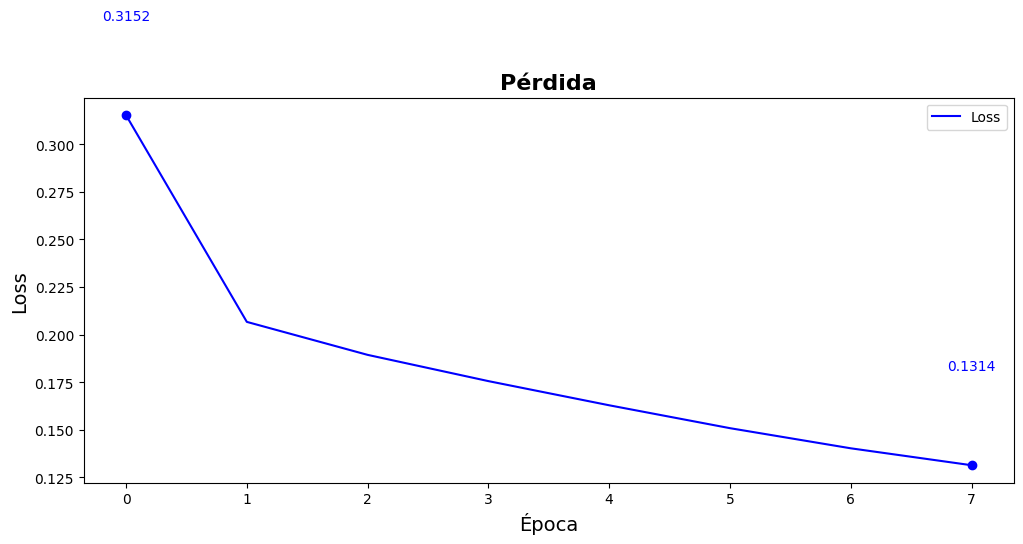

In [ ]:
# Datos
loss = hist_2.history['loss']
epochs = range(len(loss))

# Crear figura
fig, ax = plt.subplots(figsize=(12, 5))

# Curva de pérdida
ax.plot(epochs, loss, label="Loss", color='blue')

# Marcar cada 10 épocas y el último punto
for i in range(0, len(loss), 10):
    ax.scatter(i, loss[i], color='blue')
    ax.annotate(f"{loss[i]:.4f}",
                xy=(i, loss[i]),
                xytext=(i, loss[i] + 0.05),
                ha='center',
                fontsize=10,
                color='blue')

# Marcar el punto final (por si no es múltiplo de 10)
last_epoch = len(loss) - 1
if last_epoch % 10 != 0:
    ax.scatter(last_epoch, loss[-1], color='blue')
    ax.annotate(f"{loss[-1]:.4f}",
                xy=(last_epoch, loss[-1]),
                xytext=(last_epoch, loss[-1] + 0.05),
                ha='center',
                fontsize=10,
                color='blue')

# Estilo del gráfico
ax.set_title('Pérdida', fontsize=16, fontweight="bold")
ax.set_xlabel('Época', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend()

plt.show()

### Bleu

En esta sección se evalua el modelo utilizando la métrica BLEU. Esta métrica mide qué tan parecida es la respuesta generada por el modelo en comparación con una respuesta esperada, analizando cuántas palabras y combinaciones de palabras coinciden. Se prueba el modelo con 100 ejemplos y se calcula un puntaje promedio para tener una idea general del rendimiento. Además, se imprimen algunas respuestas generadas para ver cómo se comporta el modelo en la práctica.

In [ ]:
# Ejemplo de evaluación del modelo usando BLEU o ROUGE
# predictions = model.predict(test_data)
# print("BLEU Score:", sentence_bleu(reference_sentences, predictions))
smoothie = SmoothingFunction().method4

bleu_scores = []

# Evaluamos, por ejemplo, 100 muestras del conjunto de test
for i in range(100):
    input_text = test_data[i]['dialog'][0]
    reference = test_data[i]['dialog'][1]

    print("Entrada: ", input_text)

    prediction = decode_sequence(input_text, tokenizer, model_2, max_len=max_len)
    print("Respuesta: ", prediction)
    print("Referencia: ", reference)
    print("\n")
    ref_tokens = reference.lower().split()
    pred_tokens = prediction.lower().split()

    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
    bleu_scores.append(bleu)

print(f"BLEU promedio en 100 muestras: {np.mean(bleu_scores):.4f}")

Entrada:  Hey man , you wanna buy some weed ? 
Respuesta:  yes , i am .
Referencia:   Some what ? 


Entrada:  The taxi drivers are on strike again . 
Respuesta:  that's right .
Referencia:   What for ? 


Entrada:  We've managed to reduce our energy consumption in our factory by about 15 per cent in the last two years . 
Respuesta:  the inspection bureau is built on the inspection bureau . losses must be covered by waterproof and binding on the inspection bureau .
Referencia:   That's excellent . How have you managed that ? 


Entrada:  Believe it or not , tea is the most popular beverage in the world after water . 
Respuesta:  i see . i like the idea .
Referencia:   Well , people from Asia to Europe all enjoy tea . 


Entrada:  What are your personal weaknesses ? 
Respuesta:  i have a master's degree in mind . i have a master's degree in mind . i have a reading degree in writing training school .
Referencia:   I ’ m afraid I ’ m a poor talker . I ’ m not comfortable talking with the 

El BLEU promedio obtenido en 100 muestras fue de 0.0263, lo que indica una baja coincidencia entre las respuestas generadas por el modelo y las respuestas de referencia del dataset. Además, se observa una reducción en el desempeño en comparación con el modelo anterior, lo que sugiere que aumentar la complejidad del modelo no necesariamente mejora su rendimiento. Este resultado plantea la necesidad de reconsiderar la arquitectura utilizada o de ajustar otros aspectos del entrenamiento para lograr un mejor desempeño.

### Rouge

Esta parte del código sirve para evaluar la calidad de las respuestas generadas por el modelo. Utiliza una métrica llamada ROUGE, que compara las respuestas del modelo con las respuestas reales (esperadas) y calcula qué tan parecidas son. Se evalúan tres tipos: ROUGE-1, ROUGE-2 y ROUGE-L, y al final se muestra un promedio de cada una para tener una idea general del desempeño del modelo en los datos de prueba.

In [ ]:
# Evaluación con ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

# Usa un subconjunto de test_data para acelerar el proceso si es muy grande
for example in tqdm(test_data.select(range(100))):  # Cambia el rango si quieres evaluar más
    input_text = example['dialog'][0]  # Asume que dialog es una lista [input, response]
    reference_text = example['dialog'][1]  # Ground truth

    generated_text = decode_sequence(input_text, tokenizer, model_2)

    scores = scorer.score(reference_text, generated_text)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Promedios
print("\n")
print(f"ROUGE-1 promedio: {np.mean(rouge1_scores):.4f}")
print(f"ROUGE-2 promedio: {np.mean(rouge2_scores):.4f}")
print(f"ROUGE-L promedio: {np.mean(rougeL_scores):.4f}")

100%|██████████| 100/100 [01:40<00:00,  1.00s/it]



ROUGE-1 promedio: 0.1368
ROUGE-2 promedio: 0.0201
ROUGE-L promedio: 0.1297


En conjunto, estas métricas refuerzan la observación hecha con la puntuación BLEU: el aumento en la complejidad del modelo no solo no mejora el rendimiento, sino que en este caso lo perjudica.

## 6. Presentación de Resultados y Conclusiones

| Modelo   | Configuración Principal                 | Val_loss | BLEU   | ROUGE-1 | ROUGE-2 | ROUGE-3 |
| -------- | --------------------------------------- | -------- | ------ | ------- | ------- | ------- |
| modelo   | embed_dim=128, num_heads=4, ff_dim=512  | 0.1984   | 0.0463 | 0.1624  | 0.0464  | 0.1556  |
| modelo_2 | embed_dim=256, num_heads=6, ff_dim=1024 | 0.1314   | 0.0268 | 0.1368  | 0.0201  | 0.1297  |

Aunque el modelo 2 presenta una menor _val_loss_, lo que indica un mejor ajuste durante el entrenamiento, el modelo 1 demuestra un rendimiento superior en el resto de metricas. Su mayor puntaje BLEU sugiere una mejor coincidencia con las respuestas esperadas, y sus resultados más altos en ROUGE-1, ROUGE-2 y ROUGE-L reflejan una mayor coherencia local y preservación de la estructura global del texto. Por estas razones se decidió escoger el primer modelo como el mejor. No obstante, cabe destacar que el rendimiento de ambos modelos es bajo en términos absolutos, por lo que se desaconseja su implementación sin antes realizar mejoras significativas.


In [ ]:
model.save("NPL.keras")

In [ ]:
model_2.save("NPL_2.keras")